In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gplearn.gplearn.genetic import SymbolicRegressor
from gplearn.gplearn.model import ShapeNN
import torch
from temperature import generate_data

import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from nam.config import defaults
from nam.data import FoldedDataset
from nam.data import NAMDataset
from nam.models import NAM, FeatureNN
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams


from nam.data import load_gallup_data, load_housing_data, load_sklearn_housing_data, load_breast_data

import sklearn

(array([  2.,   7.,   9.,  18.,  19., 247.,  42.,  41.,  56.,  41.,  48.,
        340.,  20.,  20.,  31.,  22.,  15.,  11.,   8.,   3.]),
 array([-96.70526648, -79.30820348, -61.91114047, -44.51407747,
        -27.11701446,  -9.71995146,   7.67711155,  25.07417455,
         42.47123756,  59.86830056,  77.26536357,  94.66242657,
        112.05948958, 129.45655258, 146.85361559, 164.25067859,
        181.6477416 , 199.0448046 , 216.4418676 , 233.83893061,
        251.23599361]),
 <BarContainer object of 20 artists>)

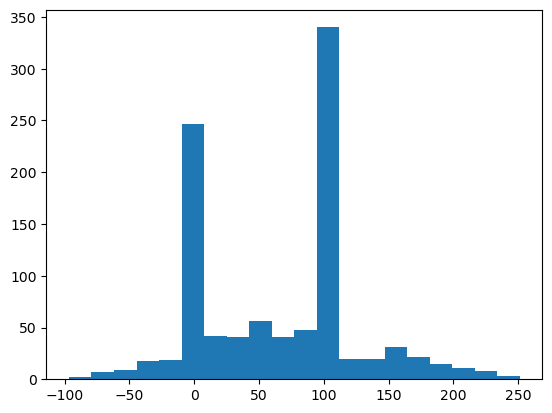

In [3]:
df = generate_data(1000, (1,800), (1.0,1.5), (-100,-10), seed=0, noise=0.0)

feature_columns = ['energy','mass','initial_temp']
target_column = 'temperature'

X = df[feature_columns].values
y = df[target_column].values

# plt.hist(X[:,0]/X[:,1])
plt.hist(y,bins=20)

In [5]:
task = 'regression'
global_seed = 0
config = defaults()
config.regression=True

constructor_dict_FeatureNN = {
    'config':config,
    'name':'FeatureNN',
    'input_shape':1,
    'num_units':1000,
    'feature_num':0
}
constructor_dict_ShapeNN = {
    'n_hidden_layers':5,
    'width':20,
    'activation_name':'ELU'
        }


gp_config = {
    'population_size':10,
    'generations':1,
    'function_set':('add','mul','div','shape'),
    'verbose':True,
    'random_state':global_seed,
    'const_range':None,
    'n_jobs':5,
    'p_crossover':0.55,
    'p_subtree_mutation':0.15,
    'p_point_mutation':0.15,
    'p_hoist_mutation':0.05,
    'p_point_replace':0.2,
    'parsimony_coefficient':0.0,
    'metric': ('mse' if task == 'regression' else 'log loss'),
    'parsimony_coefficient':0.0,
    'optim_dict': {
        'alg':'adam',
        'lr': 1e-2,
        'max_n_epochs':500,
        'tol':1e-3,
        'n_iter_no_change':10,
        'task':task,
        'device':'cuda',
        'batch_size':2000,
        'shape_class':ShapeNN,
        'constructor_dict': constructor_dict_ShapeNN,
        'num_workers_dataloader': 0,
        'seed':0
        }
    }
                           
# esr_parameter_dict = {
#     # 'parsimony_coefficient': scipy.stats()
#     'optim_dict': DictionaryDistribution({
#         'alg':['adam'],
#         'lr': scipy.stats.loguniform(1e-5,1),
#         'max_n_epochs':[200],
#         'tol':[1e-4],
#         'n_iter_no_change':[10],
#         'task':[task],
#         'device':['cuda'],
#         'batch_size':[20000]
#     })
# }

esr = SymbolicRegressor(**gp_config, categorical_variables={})
esr.fit(X,y)

AssertionError: Torch not compiled with CUDA enabled

In [21]:
numerical_arguments = {
    0: (1.0,1200),
    1: (1.0,1.5),
    2: (-100,-10)
}
categorical_arguments = {}

In [3]:
from gplearn.gplearn.functions import _function_map
from gplearn.gplearn.fitness import _fitness_map
from gplearn.gplearn.utils import check_random_state
from gplearn.gplearn._program import _Program

program_config = {
'function_set' : [_function_map['add'],_function_map['sub'],_function_map['mul'],_function_map['div'],_function_map['shape']],
'arities' : {1: [_function_map['shape']], 2: [_function_map['add'],_function_map['sub'],_function_map['mul'],_function_map['div']]},
'init_depth' : (2,5),
'init_method' : 'half and half',
'n_features' : 3,
'const_range' : None,
'metric' : _fitness_map['mse'],
'p_point_replace' : 0.2,
'parsimony_coefficient' : 0.0,
'random_state': check_random_state(global_seed+1),
'optim_dict': {
        'alg':'adam',
        'lr': 1e-2,
        'max_n_epochs':1000,
        'tol':1e-3,
        'n_iter_no_change':10,
        'task':task,
        'device':'cpu',
        'batch_size':5000,
        'shape_class':ShapeNN,
        'constructor_dict': constructor_dict_ShapeNN,
        'num_workers_dataloader': 0,
        'seed':0
        }
}

# for i in range(10):
#     program = _Program(**program_config)
#     print(program)

program_list = [_function_map['shape'],_function_map['add'],_function_map['div'],0,1,_function_map['shape'],2]
program = _Program(**program_config, program=program_list)

NameError: name 'global_seed' is not defined

In [ ]:
device = torch.device('cpu')
# params['ohe_matrices'] = self._create_ohe_matrices(X,self.categorical_variables, device=device)

X_t = torch.from_numpy(np.array(X)).float().to(device)
y_t = torch.from_numpy(np.array(y)).float().to(device)
program.raw_fitness(X_t,y_t,sample_weight=np.ones(X_t.shape[0]),ohe_matrices={})

In [8]:
%reload_ext tensorboard

In [9]:
%tensorboard --logdir tb_logs

{1: (-100, -10), 0: (-130.12759908040366, 1119.5237121582031)}


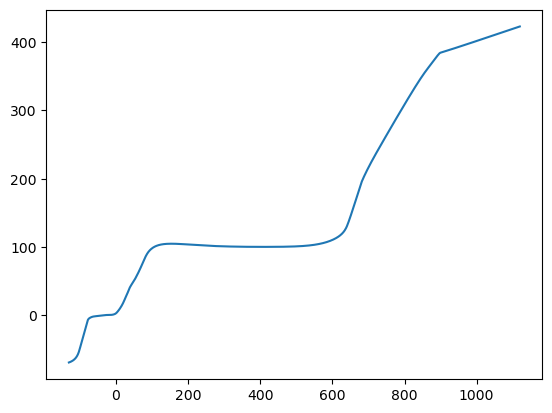

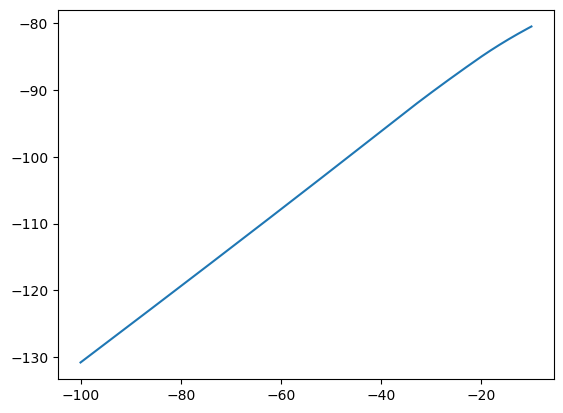

In [19]:
program.plot_shape_functions(numerical_arguments, categorical_arguments, steps=1000)

In [3]:
config = defaults()
config.cross_val = True
config.l2_regularization=1.0
config.regression=True
print(config)

Config(device='cpu', seed=2021, data_path='data/GALLUP.csv', experiment_name='NAM', regression=True, num_epochs=10, lr=0.01, batch_size=128, logdir='output', wandb=False, hidden_sizes=[], activation='exu', dropout=0.1, feature_dropout=0.1, decay_rate=0.995, l2_regularization=1.0, output_regularization=0.1, num_basis_functions=1000, units_multiplier=2, shuffle=True, cross_val=True, num_folds=5, num_splits=3, fold_num=1, num_models=1, num_workers=16, save_model_frequency=2, save_top_k=3, use_dnn=False, early_stopping_patience=50)


In [16]:
# dataset = load_sklearn_housing_data(config)

df = generate_data(1000, (0,800), (1,10), (-100,0), seed=0)

feature_columns = ['mass','energy','initial_temp']
target_column = 'temperature'

dataset = FoldedDataset(config,
                      data_path=df,
                      features_columns=feature_columns,
                      targets_column=target_column)

dataloaders = dataset.train_dataloaders()
model = NAM(
  config=config,
  name="NAM",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
model


C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\torch\nn\init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (dropout): Dropout(p=0.1, inplace=False)
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): Linear(in_features=1000, out_features=1, bias=True)
      )
    )
    (1): FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): Linear(in_features=1000, out_features=1, bias=True)
      )
    )
    (2): FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): Linear(in_features=1000, out_features=1, bias=True)
      )
    )
  )
)

In [17]:
for fold, (trainloader, valloader) in enumerate(dataloaders):

    tb_logger = TensorBoardLogger(save_dir=config.logdir,
                                name=f'{model.name}',
                                version=f'fold_{fold + 1}')

    checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir +
                                        "/{epoch:02d}-{val_loss:.4f}",
                                        monitor='val_loss',
                                        save_top_k=config.save_top_k,
                                        mode='min')

    litmodel = LitNAM(config, model)
    trainer = pl.Trainer(logger=tb_logger,
                       max_epochs=config.num_epochs,)
                    #    checkpoint_callback=checkpoint_callback)
    trainer.fit(litmodel,
              train_dataloaders=trainloader,
              val_dataloaders=valloader)

2023-01-20 23:25:48.015 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[1]: train: 582, val: 84
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory output\NAM\fold_1\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 6.0 K 
-------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model p

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\trainer\trainer.py:1600: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Train

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
2023-01-20 23:25:49.139 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[2]: train: 582, val: 84
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory output\NAM\fold_2\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 6.0 K 
-------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
2023-01-20 23:25:50.260 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[3]: train: 582, val: 84
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory output\NAM\fold_3\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 6.0 K 
-------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
2023-01-20 23:25:51.408 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[4]: train: 582, val: 84
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory output\NAM\fold_4\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 6.0 K 
-------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
2023-01-20 23:25:52.529 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[5]: train: 582, val: 84
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory output\NAM\fold_5\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 6.0 K 
-------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [11]:
trainer.test(dataloaders=dataset.test_dataloaders())

C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at output\NAM\fold_5\checkpoints\epoch=9-step=50-v1.ckpt
Loaded model weights from checkpoint at output\NAM\fold_5\checkpoints\epoch=9-step=50-v1.ckpt
C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    MAE_metric_epoch        38.216773986816406
     test_loss_epoch         2229.598388671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 2229.598388671875,
  'MAE_metric_epoch': 38.216773986816406}]

In [18]:
tb_logger

In [19]:
litmodel.to(torch.device('cuda'))

LitNAM(
  (model): NAM(
    (dropout): Dropout(p=0.1, inplace=False)
    (feature_nns): ModuleList(
      (0): FeatureNN(
        (dropout): Dropout(p=0.1, inplace=False)
        (model): ModuleList(
          (0): ExU(in_features=1, out_features=1000)
          (1): Linear(in_features=1000, out_features=1, bias=True)
        )
      )
      (1): FeatureNN(
        (dropout): Dropout(p=0.1, inplace=False)
        (model): ModuleList(
          (0): ExU(in_features=1, out_features=1000)
          (1): Linear(in_features=1000, out_features=1, bias=True)
        )
      )
      (2): FeatureNN(
        (dropout): Dropout(p=0.1, inplace=False)
        (model): ModuleList(
          (0): ExU(in_features=1, out_features=1000)
          (1): Linear(in_features=1000, out_features=1, bias=True)
        )
      )
    )
  )
)

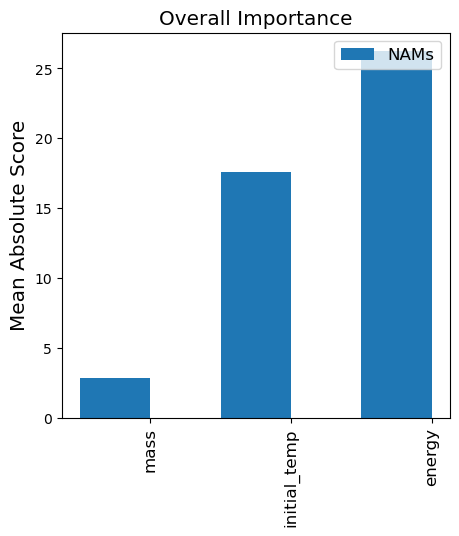

In [20]:
fig = plot_mean_feature_importance(litmodel.model, dataset)

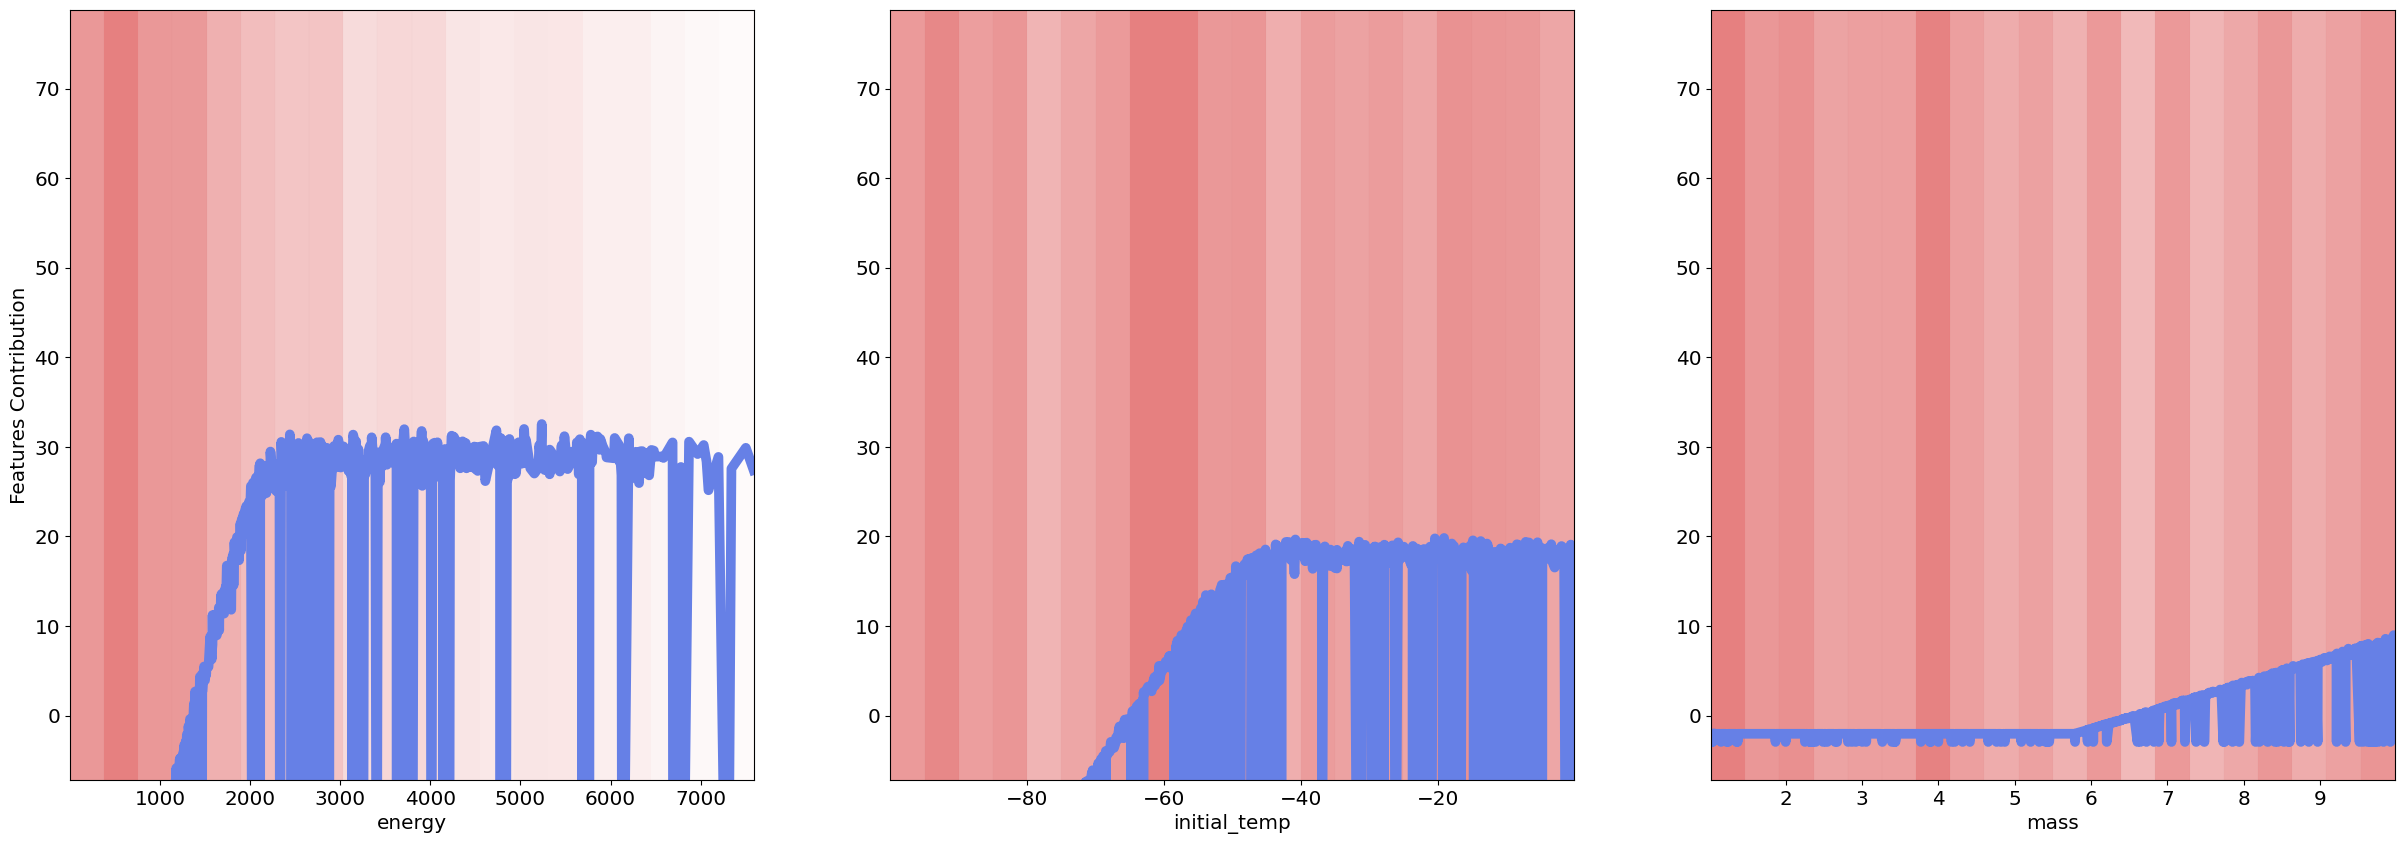

In [21]:
fig = plot_nams(litmodel.model, dataset, num_cols=3)

In [11]:
config.regression = True


housing = sklearn.datasets.fetch_california_housing()

dataset = pd.DataFrame(data=housing.data, columns=housing.feature_names)
dataset['target'] = housing.target

config.regression = True

dataset = NAMDataset(config,
                      data_path=dataset,
                      features_columns=dataset.columns[:-1],
                      targets_column=dataset.columns[-1])

dataloaders = dataset.train_dataloaders()



C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\torch\nn\init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [4]:
config = defaults()
config.cross_val = True
config.regression = True
print(config)

dataset = NAMDataset(config,
                      data_path=df,
                      features_columns=feature_columns,
                      targets_column=target_column)
     

model = NAM(
  config=config,
  name="NAM_TEST",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
model._num_units

Config(device='cuda', seed=2021, data_path='data/GALLUP.csv', experiment_name='NAM', regression=True, num_epochs=10, lr=0.01, batch_size=128, logdir='output', wandb=False, hidden_sizes=[], activation='exu', dropout=0.1, feature_dropout=0.1, decay_rate=0.995, l2_regularization=0.1, output_regularization=0.1, num_basis_functions=1000, units_multiplier=2, shuffle=True, cross_val=True, num_folds=5, num_splits=3, fold_num=1, num_models=1, num_workers=16, save_model_frequency=2, save_top_k=3, use_dnn=False, early_stopping_patience=50)


C:\Users\krkac\Miniconda3\envs\esr\lib\site-packages\torch\nn\init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


[1000, 1000, 1000]

In [6]:
program = esr._program

AttributeError: 'SymbolicRegressor' object has no attribute '_program'

In [108]:
print(program)

div(add(shape(X0), shape(X2)), shape(X1))


{1: (-100, -10), 0: (0.7501503586769104, 8000.650847971439)}


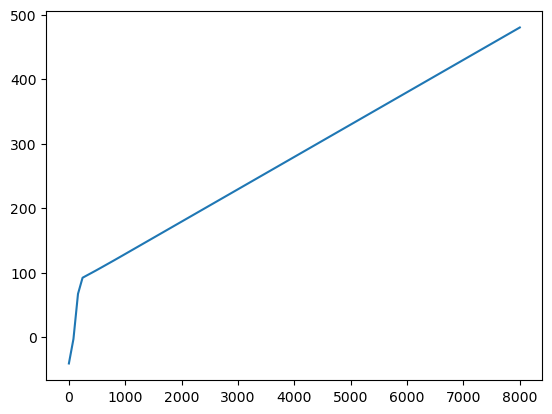

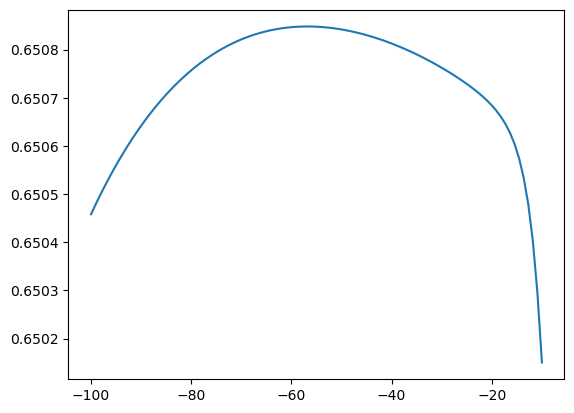

In [34]:
program.plot_shape_functions(numerical_arguments, categorical_arguments, steps=100)

In [15]:
import tensorboard

In [13]:
program.execute(X_t[0:2,:],ohe_matrices={})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

array([-0.6238792, 67.19823  ], dtype=float32)

In [113]:
a = X_t[0:2,:]

In [114]:
a[:,0]/a[:,1]

tensor([513.1998, 223.1315])

In [125]:
a

tensor([[ 5.7328e+02,  1.1171e+00, -1.2045e+01],
        [ 1.8854e+03,  8.4499e+00, -9.4596e+01]])

In [124]:
y_t

tensor([100.0000,  96.1134,   0.0000, -28.7304, 100.0000, 100.0000, 100.0000,
        100.0000, 100.0000, 100.0000, 100.0000, -69.5953, 100.0000,   0.0000,
        100.0000,  51.5546, 100.0000, 100.0000, 100.0000, 100.0000,   0.0000,
         19.6202, 100.0000, 100.0000, 100.0000, 100.0000, 225.4676, 202.5260,
        100.0000, 100.0000, 100.0000, 100.0000,   0.0000, 100.0000, 100.0000,
        100.0000, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000,
        100.0000, 100.0000, 100.0000, 100.0000,  69.4599, 100.0000,   0.0000,
        100.0000, 100.0000,  98.5386, 100.0000,   0.0000, 100.0000,  17.1404,
        100.0000, 100.0000,  91.7330,   0.0000, 100.0000,  58.2833,   0.0000,
        100.0000, 100.0000, 100.0000,  45.2275, 127.3623, 100.0000,   0.0000,
        100.0000, 100.0000, 100.0000, 171.7031, 100.0000, 100.0000, 100.0000,
        187.1567, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000,
        100.0000, 100.0000, 100.0000, 100.0000,  11.1266, 100.00

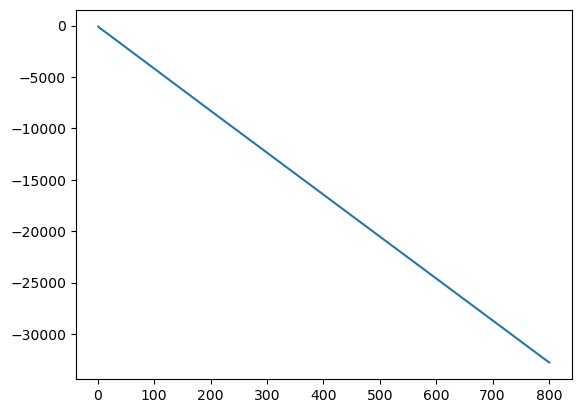

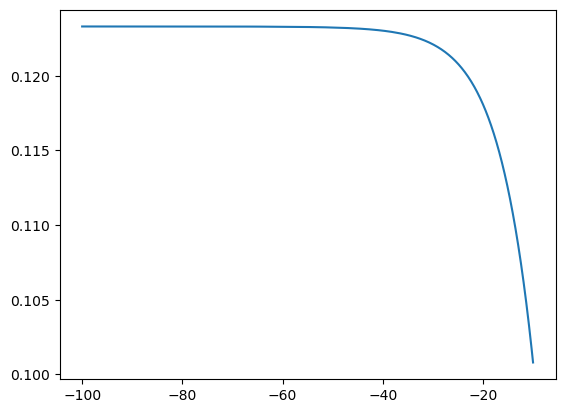

In [105]:
shape_arg_ranges = {1: (-100, -10), 0: (1.1007960438728333, 800.1233030259609)}
shapes = program.model.shape_functions
for i, shape in enumerate(shapes):
    t = torch.linspace(shape_arg_ranges[i][0],shape_arg_ranges[i][1],steps=1000)
    shape.to(torch.device('cpu'))
    with torch.no_grad():
        y = shape(t).flatten()
        plt.plot(t.numpy(),y.numpy())
        plt.show()

In [106]:
shapes

ModuleList(
  (0): ShapeNN(
    (input_layer): Linear(in_features=1, out_features=10, bias=True)
    (input_activation): ELU(alpha=1.0)
    (output_layer): Linear(in_features=10, out_features=1, bias=True)
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=10, out_features=10, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=10, out_features=10, bias=True)
      (9): ELU(alpha=1.0)
      (10): Linear(in_features=10, out_features=10, bias=True)
      (11): ELU(alpha=1.0)
      (12): Linear(in_features=10, out_features=10, bias=True)
      (13): ELU(alpha=1.0)
      (14): Linear(in_features=10, out_features=10, bias=True)
      (15): ELU(alpha=1.0)
      (16): Linear(in_features=10, out_features=10, bias=True)
